In [1]:
%matplotlib inline
#%matplotlib notebook
import gui
from IPython.display import display
from ipywidgets import Text


# Set plot layout
#plt.style.use('seaborn-notebook')
#sns.set_style("white")
#sns.set_style("ticks")
#sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# TODO this should be moved into ppWidget
#ffolder = '/home/malte/MeasurmentData/00001/00/'
'/home/malte/MeasurmentData/2016/09/08/'
'/home/malte/MeasurmentData/2016/09/07/'
'/home/malte/MeasurmentData/2016/09/06/'
'/home/malte/MeasurmentData/sudipta/2016/08/29/'
ftext = Text(
    description='Folder',
    value='D:/',
    tooltip='Path to data folder',
)

def ftext_update(*args):
    global ppWidget, observer
    ppWidget, observer = gui.update_ffolder(ffolder=ftext.value, observer=observer, ppWidget=ppWidget)

ftext.observe(ftext_update, "value")


ppWidget, observer = gui.gen_PumpProbeWidget(ftext.value)

/media/sf_deiseroth/Analysis/SFG2D/dashboards/pump-probe/gui.py:153: UserWarning: No ppWidget.json file in D:
  warnings.warn('No ppWidget.json file in %s' % ffolder)


# Define Root Folder

Examples are `D:\deiseroth\2016\08\01\` or `D:\das\2016\09\12\`. Note the `\` at the end.

In [2]:
display(ftext)

## IR Profile

In [3]:
ppWidget.w_ir(title='IR Profile', y_label='Counts')

/home/malte/Analysis/SFG2D/dashboards/MyWidgets.py:126: UserWarning: File does not exist. Skipping update
/home/malte/MeasurmentData/2016/09/08
/home/malte/MeasurmentData/2016/09/08
  % (fpath, fbase))
/home/malte/Analysis/SFG2D/dashboards/MyWidgets.py:219: UserWarning: File does not exist. Skipping update
/home/malte/MeasurmentData/2016/09/08
/home/malte/MeasurmentData/2016/09/08
  % (fpath, fbase))
/home/malte/Analysis/SFG2D/dashboards/MyWidgets.py:252: UserWarning: No data to update in <SFG2D.dashboards.MyWidgets.DataImporter object at 0xaed38a2c>
  warnings.warn('No data to update in %s' % self)
/home/malte/Analysis/SFG2D/dashboards/MyWidgets.py:61: UserWarning: No data to update figure with in <SFG2D.dashboards.MyWidgets.DataImporter object at 0xaed38a2c>
  warnings.warn("No data to update figure with in %s" % self)
/home/malte/Analysis/SFG2D/io/veronica.py:255: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slo

In [15]:
import SFG2D
import pandas as pd
fname = '/home/malte/MeasurmentData/2016/09/06/01_sc_quartz_w678_gcm_e10s_ssp_pu1_pr0_vis1_gal0_chop0_purge1.dat'
#d = SFG2D.io.veronica.read_auto('/home/malte/MeasurmentData/2016/09/06/01_sc_quartz_w678_gcm_e10s_ssp_pu1_pr0_vis1_gal0_chop0_purge1.dat')
dd = pd.read_csv(fname, sep='\t')
dd.shape

(46457, 24)

In [ ]:
#ppWidget.save(ffolder)

In [ ]:
#ppdData.ir = '/19_sp_d20_w675_gcm_e20m_ssp_pu1_pr0_vis1_gal1_chop1_purge1.dat'
#ppdData.ir.df["spec_0"].clip_upper(340).plot.hist(bins=np.arange(260, 300, 2))
#ppdData.ir.df["spec_1"].clip_upper(340).plot.hist(bins=np.arange(260, 300, 2), alpha=0.5)

## Pump Profile

In [ ]:
ppWidget.w_pump(title='Pump-Vis SFG', x_label=r'Wavenumbers in 1/cm', y_label='Counts')

In [ ]:
#ppWidget.save(ffolder)

# Pump-Probe Data

In [4]:
ppWidget.w_pump_probe(title='Pump Probe Data', y_label='Counts')

/home/malte/Analysis/SFG2D/dashboards/MyWidgets.py:343: UserWarning: File does not exist. Skipping update
/home/malte/MeasurmentData/2016/08/01
/home/malte/MeasurmentData/2016/08/01
  % (fpath, fbase))
/home/malte/Analysis/SFG2D/dashboards/MyWidgets.py:232: UserWarning: No data to update in <SFG2D.dashboards.MyWidgets.DataImporter object at 0xaed38d0c>
  warnings.warn("No data to update in %s" % self)
/home/malte/Analysis/SFG2D/dashboards/MyWidgets.py:252: UserWarning: No data to update in <SFG2D.dashboards.MyWidgets.DataImporter object at 0xaed38d0c>
  warnings.warn('No data to update in %s' % self)
/home/malte/Analysis/SFG2D/dashboards/MyWidgets.py:61: UserWarning: No data to update figure with in <SFG2D.dashboards.MyWidgets.DataImporter object at 0xaed38d0c>
  warnings.warn("No data to update figure with in %s" % self)


ValueError: Lengths must match to compare

ValueError: Lengths must match to compare

ValueError: Lengths must match to compare

ValueError: Lengths must match to compare

In [ ]:
#ppWidget.save(ffolder)

# FROM HERE ON NOT YET IMPLEMENTED

## Normalize Spectra

# Spectra Over Time

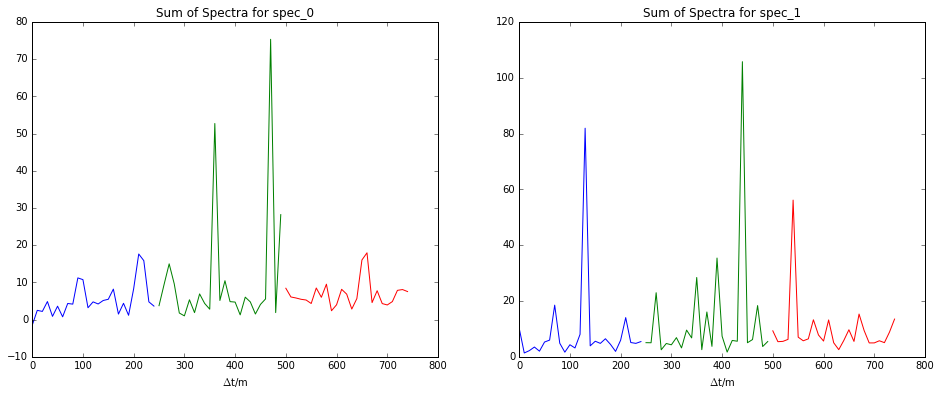

In [16]:
import SFG2D
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,2,figsize=(16,6))

def fig_sum_update(fig, ax):
    SFG2D.plotting.ts.sum_of_spectra(ppWidget.w_pump_probe.scan, ppWidget.w_pump_probe.pump_selector.value, ax[0])
    SFG2D.plotting.ts.sum_of_spectra(ppWidget.w_pump_probe.scan, ppWidget.w_pump_probe.probe_selector.value, ax[1])
    return fig, ax



In [ ]:
w_f0 = ipyw.interact(plot_compare_update, pp_delay=ppWidget.ts0_ppdelay_childs[1])
#display(w_f0)

## Smoothed

# Bleach Trace

In [ ]:
import datetime
pp_delays = 25
exp_time = 10# in minutes
reps = 3 #number of repetitions
datetime.datetime.now() + datetime.timedelta(minutes=pp_delays*exp_time*reps)